In [216]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.3f}'.format

In [217]:
# network structure. First layer number should be = number of features
net_layers = (11,16,8,4)

# trials
# 11 -> 11 -> 6
# 11 -> 8 -> 6 
# 11 -> 11 -> 8 -> 4

In [218]:
# 1- read data file
# 1- read processed file
file_dir = '../data/processed-data/'
data_file = 'standardized_normalized_dataset.csv'
data = pd.read_csv(file_dir + data_file)

In [219]:
data.head(5)

,svc_cpu_use,svc_cpu_thr,svc_net_use,svc_disk_use,system_cpu_use,system_cpu_sat,system_net_use,svc_req_size,svc_resp_size,svc_pods,svc_req_rate,ltcy
0,-2.397,-1.146,-2.165,-2.248,-1.571,-1.348,-2.094,-1.754,-1.289,-1.485,-1.998,0.332
1,-2.193,-1.270,-2.052,-2.129,-1.570,-1.347,-2.030,-1.672,-1.230,-1.485,-1.928,0.400
2,-2.221,-1.206,-2.008,-2.227,-1.571,-1.365,-2.023,-1.607,-1.181,-1.485,-1.866,0.469
3,-2.165,-1.270,-2.007,-1.404,-1.571,-1.337,-2.037,-1.624,-1.198,-1.709,-1.872,0.490
4,-2.221,-1.206,-1.955,-1.105,-1.571,-1.321,-2.049,-1.616,-1.192,-2.379,-1.862,0.500


## Function to build a model

In [220]:
targets = data['ltcy']
inputs = data.drop(['ltcy'], axis=1)

x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=0.2, random_state=365)

# for better convergence and result scale target to values between 0 - 1
maxltcy = targets.max()
y_train = y_train / maxltcy
y_test = y_test / maxltcy


In [221]:
def build_model(nodes = net_layers):   # this does not work with KerasRegressor. interesting
    # create model
    model = Sequential()  
    model.add(Dense(nodes[1], input_dim=nodes[0], kernel_initializer='normal', activation='relu'))
    
    layer = 1
    while layer < len(nodes):
        model.add(Dense(nodes[layer], kernel_initializer='normal', activation='relu'))
        layer = layer + 1
        
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))
    # Compile model
    opt = Adam(lr=1e-3, decay=1e-3 / 200)
    # or loss= 'mean_absolute_percentage_error'
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model


In [222]:
estimators = []
##estimators.append(('standardize', StandardScaler()))
regressor = KerasRegressor(build_fn=build_model, epochs=20, batch_size=5, \
                           verbose=1, shuffle=False)
estimators.append(('mlp', regressor))
pipeline = Pipeline(estimators)

kfold = KFold(n_splits=2)

results = cross_val_score(pipeline, x_train , y_train, cv=kfold)

print ("Done..!")


Epoch 1/20
633/633 [==============================] - 8s 12ms/step - loss: 0.2344
Epoch 2/20
633/633 [==============================] - 1s 854us/step - loss: 0.0253
Epoch 3/20
633/633 [==============================] - 1s 994us/step - loss: 0.0168
Epoch 4/20
633/633 [==============================] - 1s 934us/step - loss: 0.0150
Epoch 5/20
633/633 [==============================] - 1s 888us/step - loss: 0.0144
Epoch 6/20
633/633 [==============================] - 1s 1ms/step - loss: 0.0142
Epoch 7/20
633/633 [==============================] - 1s 973us/step - loss: 0.0141
Epoch 8/20
633/633 [==============================] - 1s 1ms/step - loss: 0.0140
Epoch 9/20
633/633 [==============================] - 1s 1ms/step - loss: 0.0139
Epoch 10/20
633/633 [==============================] - 1s 948us/step - loss: 0.0138
Epoch 11/20
633/633 [==============================] - 1s 1ms/step - loss: 0.0138
Epoch 12/20
633/633 [==============================] - 1s 1ms/step - loss: 0.0137
Epoch 13/20


Text(0, 0.5, 'mean_squared_error')

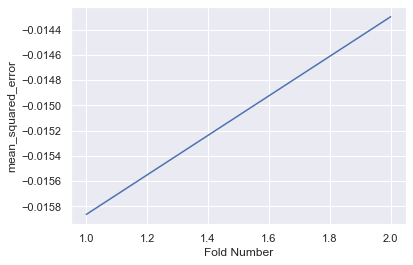

In [223]:
folds = range(1, results.size + 1)

plt.plot( folds , results)
plt.xlabel('Fold Number')
plt.ylabel('mean_squared_error')


In [242]:
# plot training history
#plt.plot(results.history['mse'], label='train')
#plt.plot(results.history['val_mse'], label='test')
#plt.legend()
#plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'history'

In [224]:
regressor = pipeline.named_steps.mlp
print("Model Result (mean and std of error): %.2f (%.2f) MSE" % (results.mean(), results.std()))

Model Result (mean and std of error): -0.02 (0.00) MSE


In [225]:
regressor.fit(x_train, y_train)
y_hat = regressor.predict(x_train)
y_hat = pd.Series(y_hat)
y_hat.head()

Epoch 1/20
1267/1267 [==============================] - 8s 6ms/step - loss: 0.1279
Epoch 2/20
1267/1267 [==============================] - 1s 878us/step - loss: 0.0176
Epoch 3/20
1267/1267 [==============================] - 1s 897us/step - loss: 0.0157
Epoch 4/20
1267/1267 [==============================] - 1s 760us/step - loss: 0.0153
Epoch 5/20
1267/1267 [==============================] - 1s 748us/step - loss: 0.0151
Epoch 6/20
1267/1267 [==============================] - 1s 717us/step - loss: 0.0150
Epoch 7/20
1267/1267 [==============================] - 1s 724us/step - loss: 0.0149
Epoch 8/20
1267/1267 [==============================] - 1s 725us/step - loss: 0.0147
Epoch 9/20
1267/1267 [==============================] - 1s 737us/step - loss: 0.0146
Epoch 10/20
1267/1267 [==============================] - 1s 851us/step - loss: 0.0145
Epoch 11/20
1267/1267 [==============================] - 1s 904us/step - loss: 0.0144
Epoch 12/20
1267/1267 [==============================] - 1s 894us

0   0.617
1   0.481
2   0.431
3   0.628
4   0.710
dtype: float32

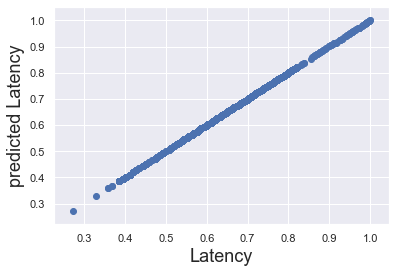

In [226]:
plt.scatter(y_train, y_train)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
#plt.xlim(-2,3)
#plt.ylim(-3,1)
plt.show()

Text(0.5, 1.0, 'Residual PDF')

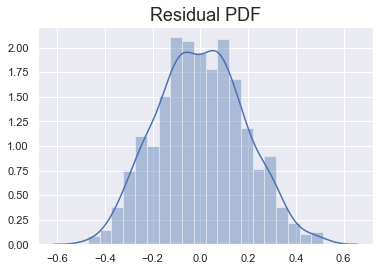

In [227]:
sns.distplot(y_train - y_hat)
plt.title('Residual PDF', size=18)

In [228]:
# evaluation mean_absolute_percentage_error
train_error =  np.abs(y_train - y_hat)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)

print("Model Result (mean - std of error - min - max): %.2f (%.2f) %.2f %.2f MSE" \
      % (mean_error, std_error, min_error, max_error))

Model Result (mean - std of error - min - max): 0.15 (0.10) 0.00 0.51 MSE


### Testing

In [229]:
y_hat_test = regressor.predict(x_test)
y_hat_test = pd.Series(y_hat_test)
y_hat_test.head()

317/317 [==============================] - 0s 580us/step


0   0.637
1   0.684
2   0.513
3   0.676
4   0.716
dtype: float32

<function matplotlib.pyplot.show(*args, **kw)>

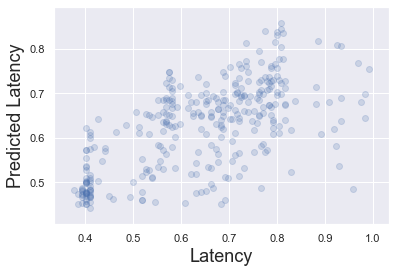

In [230]:
plt.scatter(y_test, y_hat_test, alpha=0.2)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

In [231]:
perf = pd.DataFrame(np.exp(y_hat_test), columns=['prediction'])
y_test = y_test.reset_index(drop=True)
perf['target'] = np.exp(y_test)
perf.head()

,prediction,target
0,1.891,1.767
1,1.982,1.778
2,1.670,1.682
3,1.967,2.266
4,2.045,1.819


In [232]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

,prediction,target,residual,difference%
0,1.891,1.767,0.124,7.013
1,1.982,1.778,0.204,11.468
2,1.670,1.682,-0.012,0.694
3,1.967,2.266,-0.299,13.192
4,2.045,1.819,0.226,12.432
...,...,...,...,...
312,2.126,2.700,-0.574,21.250
313,1.883,2.134,-0.250,11.731
314,2.068,2.266,-0.198,8.719
315,1.840,2.238,-0.397,17.754


In [233]:
perf.describe()

,prediction,target,residual,difference%
count,317.000,317.000,317.000,317.000
mean,1.875,1.921,-0.045,9.065
std,0.186,0.292,0.228,6.553
min,1.555,1.457,-0.985,0.057
25%,1.705,1.704,-0.166,3.893
50%,1.900,1.940,-0.012,7.665
75%,2.004,2.143,0.117,12.713
max,2.359,2.700,0.367,37.785


In [234]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
perf.sort_values(by = ['difference%'])

,prediction,target,residual,difference%
220,1.65,1.65,-0.00,0.06
238,1.79,1.79,-0.00,0.12
252,1.70,1.69,0.00,0.29
279,2.16,2.15,0.01,0.30
105,1.98,1.97,0.01,0.31
87,1.98,1.99,-0.01,0.39
9,1.69,1.69,-0.01,0.41
132,1.93,1.94,-0.01,0.43
186,1.59,1.58,0.01,0.52
142,1.69,1.70,-0.01,0.56


# Prediction Accuracy

In [235]:
# validation mean_absolute_percentage_error (MAPE)
test_error = np.absolute(perf['residual'] / perf['target'])
mean_error = np.mean(test_error)
min_error = np.min(test_error)
max_error = np.max(test_error)
std_error = np.std(test_error)

print("Mean Absolute Percentate Error std of error (MAPE): [mean: %.2f std: %.2f max: %.2f min: %.2f]" \
      % (mean_error, std_error, max_error, min_error))


Mean Absolute Percentate Error std of error (MAPE): [mean: 0.09 std: 0.07 max: 0.38 min: 0.00]


In [236]:
# validation mean_squared_error  (MSE)
test_error =  np.power(perf['residual'] , 2)
mean_error = np.mean(test_error)
min_error = np.min(test_error)
max_error = np.max(test_error)
std_error = np.std(test_error)

print("Mean Squared Error (MSE): [mean: %.2f std: %.2f max: %.2f min: %.2f]" \
      % (mean_error, std_error, max_error, min_error))


Mean Squared Error (MSE): [mean: 0.05 std: 0.10 max: 0.97 min: 0.00]


R2 is a statistic that will give some information about the goodness of fit of a model. In regression, the R2 coefficient of determination is a statistical measure of how well the regression predictions approximate the real data points. An R2 of 1 indicates that the regression predictions perfectly fit the data.

In [237]:
# R-Squared 
# = 1 -  ( sum of squared residual  / sum of squared variance )
# sum of variance squared = sum (( y - y-mean ) ** 2)
# sum of residual squared = sum (( y-hat - y-mean ) ** 2)
# where y is the observed target, y-mean is the mean of observed target, y-hat is a predicted value

y_mean = np.mean(targets)
sum_squared_residual = np.sum(np.power(perf['residual'] , 2))
sum_squared_variance = np.sum(np.power(targets - y_mean , 2))

R_squared = 1 - ( sum_squared_residual / sum_squared_variance )

R_squared


0.7028179863304214